In [23]:
import json
import os
import sys
sys.path.append("../resources/example-scripts/explainable-ai/eigencam-yolov8")


import cv2
import matplotlib.pyplot as plt
import numpy as np
import patchify
from tqdm import tqdm
from ultralytics import YOLO

from yolov8_cam.eigen_cam import EigenCAM


%matplotlib inline

In [24]:
DATA_SPLIT_PATH = "/mnt/folcon/02_model_input/data_split.json"
MODEL_PATH = "/home/vblot/yolo_ultralytics/runs/detect/train5/weights/best.pt"
OVARY_PATH = "/mnt/folcon/01_ovary_cuts/ovaries_images"
PATCH_SIZE = 1000
CLASS_NAME_VALUES = {0: "PMF", 1: "Primary", 2: "Secondary"}
BBOXES_SIZE_PARAMS = {
    "PMF": {"width": 200, "height": 200},
    "Primary": {"width": 350, "height": 350},
    "Secondary": {"width": 450, "height": 450}
}

In [25]:
with open(DATA_SPLIT_PATH, "r") as f:
    data_split = json.load(f)

In [26]:
slide_name, roi_name = data_split["test"][0], "roi0"
cut_name = os.listdir(os.path.join(OVARY_PATH, slide_name))[0]
slide_name, cut_name

('4C_e', '4C_e__roi2.tif')

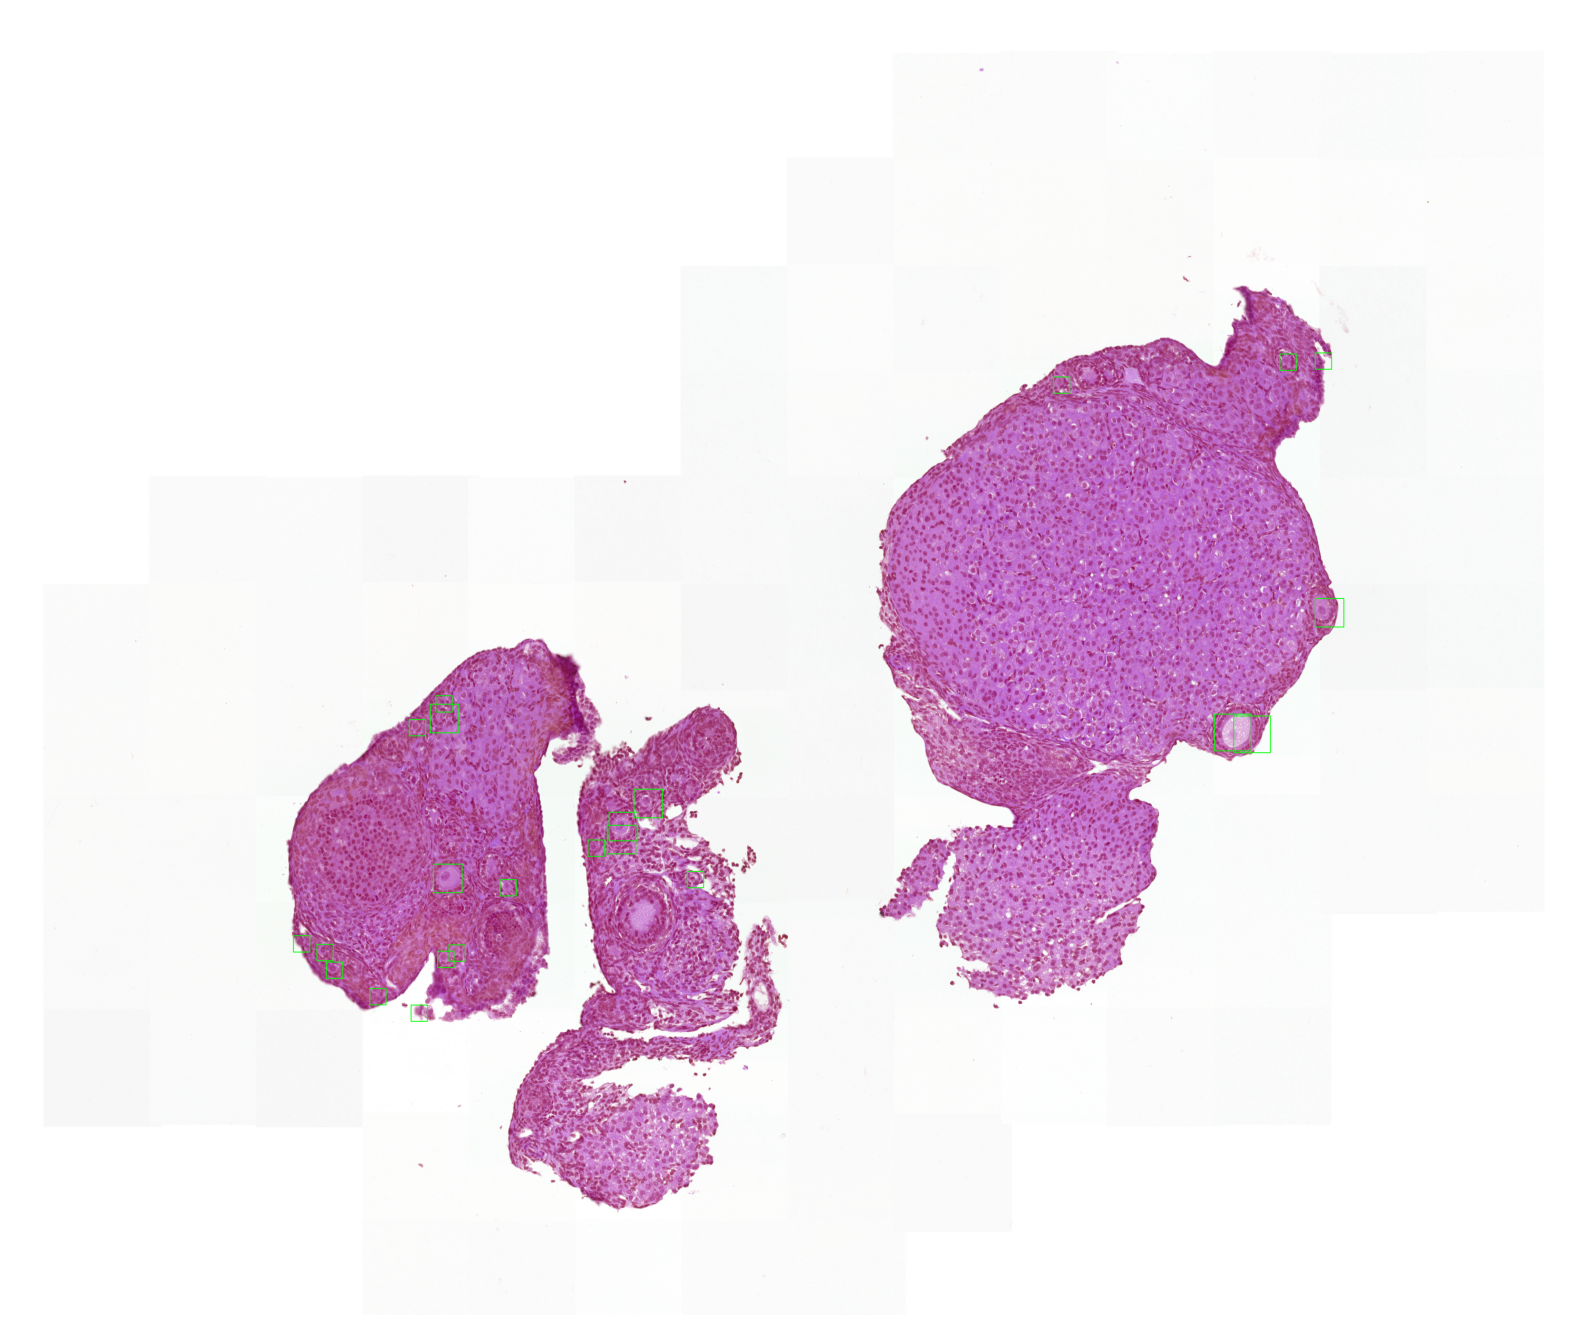

In [15]:
model = YOLO(MODEL_PATH)
target_layers = [model.model.model[-4]]
cam = EigenCAM(model, target_layers,task='od')
principal_comp = [7,8,9]

cut = cv2.imread(os.path.join(OVARY_PATH, slide_name, cut_name))
patches = patchify.patchify(cut, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)
n_rows, n_cols = patches.shape[:2]
s = 20
fig, axs = plt.subplots(1, 1, figsize=(s, s))
for ix in range(n_rows):
    for iy in range(n_cols):
        patch_row = ix
        patch_col = iy
        patch = patches[ix, iy, 0]
        result = model(patch, verbose=False)[0]
        pred_boxes = result.boxes.xyxy.detach().cpu().numpy()
        pred_confs = result.boxes.conf.detach().cpu().numpy()
        pred_classes = result.boxes.cls.detach().cpu().numpy()

        grayscale_cam = cam(
                    patch,
                    eigen_smooth=True,
                    principal_comp=[1],
                )
        grayscale_cam = cv2.applyColorMap(np.uint8(255 * grayscale_cam[0]), cv2.COLORMAP_JET)
        grayscale_cam = cv2.cvtColor(grayscale_cam, cv2.COLOR_BGR2RGB)
        cut[ix * 1000: (ix + 1) * 1000, iy * 1000: (iy + 1) * 1000] = cv2.addWeighted(patch, 0.7, grayscale_cam, 0.3, 0)
        if len(pred_boxes) > 0:
            for i in range(len(pred_boxes)):
                
                x1 = pred_boxes[i][0] + patch_col * PATCH_SIZE
                y1 = pred_boxes[i][1] + patch_row * PATCH_SIZE
                class_label = pred_classes[i]
                class_name = CLASS_NAME_VALUES[int(class_label)]
                new_bbox_width = BBOXES_SIZE_PARAMS[class_name]["width"]
                new_bbox_height = BBOXES_SIZE_PARAMS[class_name]["height"]
                new_bbox = np.zeros(4)
                new_bbox[0] = x1
                new_bbox[1] = y1
                new_bbox[2] = x1 + new_bbox_width
                new_bbox[3] = y1 + new_bbox_height
                cut = cv2.rectangle(cut, (int(new_bbox[0]), int(new_bbox[1])), (int(new_bbox[2]), int(new_bbox[3])), (0, 255, 0), 10)
axs.imshow(cut)
axs.axis("off")
plt.show()

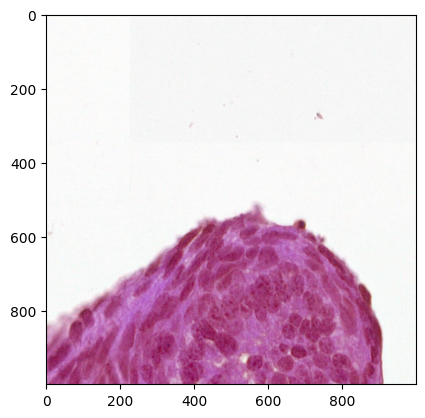

In [52]:
target_layers = [model.model.model[-4]]
cam = EigenCAM(model, target_layers,task='od')
cut = cv2.imread(os.path.join(OVARY_PATH, slide_name, cut_name))
patches = patchify.patchify(cut, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)
principal_comp = [1]
grayscale_cam = cam(
    patches[8, 8, 0],
    eigen_smooth=True,
    principal_comp=principal_comp,
)
plt.imshow(patches[8, 8, 0])

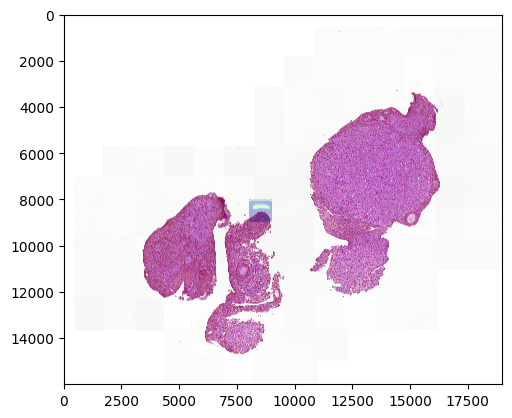

In [55]:
# # Add grayscale cam to the original image
grayscale_cam = cv2.applyColorMap(np.uint8(255 * grayscale_cam[0]), cv2.COLORMAP_JET)
grayscale_cam = cv2.cvtColor(grayscale_cam, cv2.COLOR_BGR2RGB)
cut[8000:9000, 8000:9000] = cv2.addWeighted(patches[8, 8, 0], 0.7, grayscale_cam, 0.3, 0)
plt.imshow(cut)

# plt.imshow(grayscale_cam[0], cmap="jet")

In [54]:
grayscale_cam.shape

(1, 1000, 1000, 1)

In [45]:
grayscale_cam.shape

(1, 1000, 1000, 1)